# 2022.10.30
**Experimenting around MultConv vs. MultParConv**
- Vec() : from np.reshape() --> definition in the reference.

# Torch vs. MultConv vs. MultParConv

In [1]:
%load_ext autoreload
%autoreload

In [2]:
from hlee_utils import *
from hlee_notClass_multiplexed_lee22e import *
#from hlee_notClass_multiplexed_lee22e_par import *
from icecream import ic
import torch
import torch.nn.functional as F

In [3]:
################
#  unpack()    #
################
def plot_4x4(img, co=None, fn=None):
    fig, axs = plt.subplots(4,4, figsize=(8,8))
    axs = axs.ravel()
    vmin = img.min()
    vmax = img.max()
    if co is None:
        co = len(img)
    for ico in range(co):
        axs[ico].imshow(img[ico], vmin=vmin, vmax=vmax)
    plt.tight_layout()
    if fn is not None:
        plt.savefig(fn)
        plt.close()

## Torch model

In [4]:
def load_params(model, fn_param, device):
    trained_param = torch.load(fn_param, map_location = torch.device(device))
    trained_param = {key : value.cpu()   for key,value in trained_param.items()}
    params_np     = {key : value.numpy() for key,value in trained_param.items()}
    model.load_state_dict(trained_param)

def load_img(fname, hi=None, wi=None):
    image = cv2.imread(fname)
    if hi is not None and wi is not None:
        image = cv2.resize(image,(hi,wi))
    img = get_channel_first(image)
    img = torch.tensor(img)
    return img.type(torch.FloatTensor)

In [5]:
from hlee_model import ConvNeuralNet_simple

activation = F.relu

model = ConvNeuralNet_simple(10, activation)
load_params(model, fn_param="./models/simple_model_hlee_co16.pt",device='cpu')

In [6]:
img = load_img("./cute.jpg", hi=32, wi=32)

torch.Size([16, 32, 32])


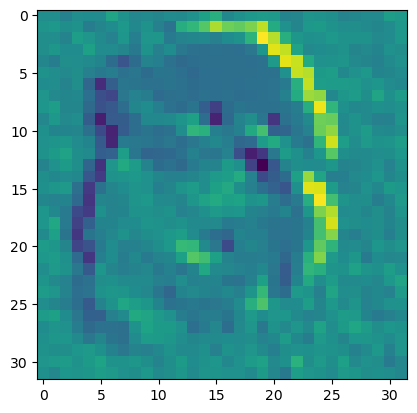

In [7]:
res1 = model.conv_layer1(img)
print(res1.shape)
plt.imshow(res1[0,:,:].detach().numpy())

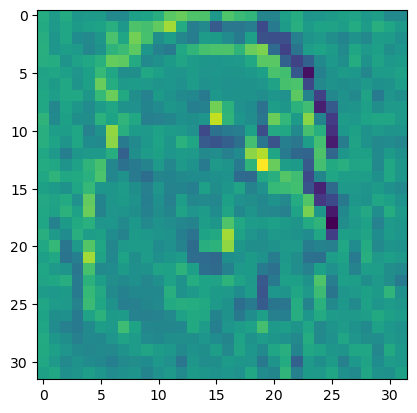

In [8]:
res2 = model.conv_layer2(res1)
plt.imshow(res2[0,:,:].detach().numpy())

In [9]:
from torch import nn
class MuxLayer():
    def __init__(self, tor):
        self.tor = tor
        
#     def _get_weight(self, name):
#         layer = getattr(self.tor, name)
#         return get_channel_last(np.array(layer.weight.detach())), layer.weight.shape    
        
    def _set_layer(self, ki, hi, wi, name):
        tor = self.tor
        layer = getattr(tor, name)
        U, Ushape = tor.layer_info(name)
        co, ci, fh, fw = Ushape
        stride, stride = layer.stride
        
        if stride == 1:
            ko = ki
            ho = hi
            wo = wi    
        else:
            ko = ki*stride
            ho = int(hi/stride)
            wo = int(wi/stride)

        ti = get_t(ci,ki)
        to = get_t(co,ko)
        pi,ins,po,outs = get_dims(hi,wi,ci,ki,ti,ho,wo,co,ko,to)
        return U, ins, outs
    
    

In [37]:
layer

NameError: name 'layer' is not defined

In [10]:
def prepare_conv(conv_layer, ki, hi, wi):
    U = get_channel_last(np.array(conv_layer.weight.detach()))
    co, ci, fh, fw = conv_layer.weight.shape
    stride, stride = conv_layer.stride

    if stride == 1:
        ko = ki
        ho = hi
        wo = wi    
    else:
        ko = ki*stride
        ho = int(hi/stride)
        wo = int(wi/stride)

    ti = get_t(ci,ki)
    to = get_t(co,ko)
    pi,ins,po,outs = get_dims(hi,wi,ci,ki,ti,ho,wo,co,ko,to)
    return U, ins, outs

def prepare_bn2d(bn_layer, ki, hi, wi):
    return U, ins, outs

def prepare_fc(bn_layer, ki, hi, wi):
    return U, ins, outs

In [ ]:
model

In [73]:
model.activation.__name__

'relu'

In [75]:
ci, hi, wi = img.shape
ki = 1
for layer in model.children():
    print(layer)
    if hasattr(layer, 'weight'):
        # Conv2d
        if isinstance(layer, torch.nn.Conv2d):
            U, ins, outs = prepare_conv(layer, ki, hi, wi)
        elif isinstance(layer, torch.nn.BatchNorm2d):
            U, ins, outs = prepare_bn2d(layer, ki, hi, wi)
        elif isinstance(layer, torch.nn.Linear):
            U, ins, outs = prepare_fc(layer, ki, hi, wi)
    elif isinstance(layer, torch.nn.AvgPool2d):
        print("Avg Pooling")
    elif layer.__name__ == "relu":
        print("Activation")
        
    print("perform conv")
    ki = outs['k']
    hi = outs['h']
    wi = outs['w']

    print(ins, outs)


Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
perform conv
{'h': 32, 'w': 32, 'c': 3, 'k': 1, 't': 3, 'p': 8} {'h': 32, 'w': 32, 'c': 16, 'k': 1, 't': 16, 'p': 2}
Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
perform conv
{'h': 32, 'w': 32, 'c': 16, 'k': 1, 't': 16, 'p': 2} {'h': 32, 'w': 32, 'c': 16, 'k': 1, 't': 16, 'p': 2}
AvgPool2d(kernel_size=2, stride=2, padding=0)
Avg Pooling
perform conv
{'h': 32, 'w': 32, 'c': 16, 'k': 1, 't': 16, 'p': 2} {'h': 32, 'w': 32, 'c': 16, 'k': 1, 't': 16, 'p': 2}
Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
perform conv
{'h': 32, 'w': 32, 'c': 16, 'k': 1, 't': 16, 'p': 2} {'h': 32, 'w': 32, 'c': 32, 'k': 1, 't': 32, 'p': 1}
BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
perform conv
{'h': 32, 'w': 32, 'c': 16, 'k': 1, 't': 16, 'p': 2} {'h': 32, 'w': 32, 'c': 32, 'k': 1, 't': 32, 'p': 1}
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
perform conv
{

In [36]:
ins

{'h': 32, 'w': 32, 'c': 3, 'k': 1, 't': 3, 'p': 8}

In [37]:
outs

{'h': 32, 'w': 32, 'c': 16, 'k': 1, 't': 16, 'p': 2}

In [13]:
ci, hi, wi = img.shape

In [13]:
ci, hi, wi = img.shape

In [13]:
imgl = get_channel_last(img)

In [22]:
ins

{'h': 32, 'w': 32, 'c': 3, 'k': 1, 't': 3, 'p': 8}

In [23]:
outs

{'h': 32, 'w': 32, 'c': 16, 'k': 1, 't': 16, 'p': 2}

In [23]:
U2, ins, outs = prepare_conv(model.conv_layer2, ki=1, hi=32, wi=32)
print(U2.shape)
U, ins, outs = prepare_conv(model.conv_layer1, ki=1, hi=32, wi=32)


(3, 3, 16, 16)


In [17]:
nslots = 2**15

outs['k'] = 2
outs['t'] = get_t(outs['c'], outs['k'])
outs['p'] = get_p(nslots, outs['h'], outs['w'], outs['k'], outs['t'])

In [18]:
outs

{'h': 32, 'w': 32, 'c': 16, 'k': 2, 't': 4, 'p': 2}

In [25]:
model.conv_layer3.weight.shape

torch.Size([32, 16, 3, 3])

In [50]:
ct_a = MultPack(imgl,ins)
U, ins, outs = prepare_conv(model.conv_layer1, ki=1, hi=32, wi=32)

In [51]:
print(ins)

{'h': 32, 'w': 32, 'c': 3, 'k': 1, 't': 3, 'p': 8}


In [34]:
out = MultConv(ct_a,U,ins,outs)
un = unpack(out,outs)

[MultConv] (hi,wi,ci) =(32,32,3),(ho,wo,co)=(32,32,16),(fh,fw)=(3,3)
[MultConv] (ki,ti) =(1,3), (ko,to) =(1,16)


In [49]:
model.conv_layer3.weight.shape

torch.Size([32, 16, 3, 3])

In [52]:
U2, ins2, outs2 = prepare_conv(model.conv_layer3, ki=outs['k'], hi=outs['h'], wi=outs['w'])
print(ins2)
print(outs2)

{'h': 32, 'w': 32, 'c': 16, 'k': 1, 't': 16, 'p': 2}
{'h': 32, 'w': 32, 'c': 32, 'k': 1, 't': 32, 'p': 1}


In [53]:
#outs2.update({'s': 2})
outs2['k'] = 2#outs2['s']
outs2['t'] = get_t(outs2['c'], outs2['k'])
outs2['p'] = get_p(nslots, outs2['h'], outs2['w'], outs2['k'], outs2['t'])


outs2['h'] = 16
outs2['w'] = 16
print(outs2)

{'h': 16, 'w': 16, 'c': 32, 'k': 2, 't': 8, 'p': 1}


In [54]:
ins2

{'h': 32, 'w': 32, 'c': 16, 'k': 1, 't': 16, 'p': 2}

In [55]:
out2 = MultConv(out,U2,ins2,outs2)
un2 = unpack(out2,outs2)

[MultConv] (hi,wi,ci) =(32,32,16),(ho,wo,co)=(16,16,32),(fh,fw)=(3,3)
[MultConv] (ki,ti) =(1,16), (ko,to) =(2,8)


In [56]:
plot_4x4(un2, 16, fn="muxed_conv3.png")

# ParMultBN

In [ ]:
bn = model.bn1

In [35]:
plot_4x4(un, fn="refactor_test.png")
plot_4x4(res1.detach().numpy(), fn="torch_test1.png")

In [21]:
def unpack(ct,dims=[]):#제대로 작동(10.31) 
    fh,fw= 3,3
    ha,wa,ca,ka,ta,pa = [dims[k] for k in dims.keys()]
    tsize = ha*wa*ka**2
    ct = ct[:ta*tsize]
    ch  = []
    nMultChs = ta*ka**2 
    for channel in range(nMultChs):
        r = channel%(ka**2)
        idx_start_channel = int(np.floor(channel/ka**2))*tsize + int(np.floor(r/ka))*wa*ka + (r%ka)
        mat=[]
        for i in range(ha):
            row = []
            for j in range(wa):
                idx = idx_start_channel+i*wa*ka**2+j*ka
                row.append(ct[idx])
            mat.append(row)
        ch.append(mat)
    return np.array(ch)

In [18]:
U2, ins2, outs2 = mux._set_layer(outs['k'], outs['h'], outs['w'], "conv_layer2")

In [19]:
out2 = MultConv(out,U2,ins2,outs2)

[MultConv] (hi,wi,ci) =(32,32,16),(ho,wo,co)=(32,32,16),(fh,fw)=(3,3)
[MultConv] (ki,ti) =(1,16), (ko,to) =(1,16)


In [62]:
un2 = unpack(out2,outs2)

In [63]:
plot_4x4(un2, fn="refactor_test2.png")
plot_4x4(res2.detach().numpy(), fn="torch_test2.png")

In [39]:
cnn = ConvNeuralNet_simple(10, nn.ReLU(inplace=True))

channel out : 0


In [40]:
model = cnn.model

In [42]:
conv = model[0]

In [45]:
conv.

AttributeError: 'Conv2d' object has no attribute 'keys'

In [112]:
#############################
#  Edit here                #
#############################
hi,wi,ci,ki,ti = 32,32, 3, 1,3
ho,wo,co,ko,to = 32,32, 16, 1,16
line = 200*np.ones([hi,2])
#############################
#  Do Not Edit              #
#############################
pi,ins,po,outs = get_dims(hi,wi,ci,ki,ti,ho,wo,co,ko,to)
nslots = 2**15
fh,fw = 3,3
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog',      'frog',       'horse','ship','truck']

# 1. 입력 이미지  size=32x32

- 이미지 크기 32x32 #channels=3 (첫번째 채널만 이미지데이터, 나머지 채널은 0)


In [3]:
#U=create_U_select(fh,fw,ci,co,"dummy")
#u = get_channel_first(U)
img = create_img_single(ins)
a =get_channel_first(img)
hstack=a[0]

for i in range(1,ci):
    hstack = np.hstack([hstack,line,a[i]])
print("\n\n+++++++++++++++++++++++++++++++++++++++++++++++++++ IMAGE ch=0 remains (others filled with zeros).")
plt.imshow(hstack,cmap='gray')
print(a[0][-1])

NameError: name 'ins' is not defined

# 2. Torch Conv (ci=3, co=4) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
channel out : 16
channel out : 16
[cnn] U_multconv  : (3, 3, 3, 16)
[cnn] U_torchconv : torch.Size([16, 3, 3, 3])


+++++++++++++++++++++++++++++++++++++++++++++++++++ TORCH out (CHANNEL :0>1>2>3)


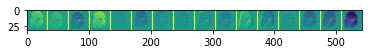

In [119]:
%load_ext autoreload
%autoreload
from hlee_cnn import *
def torch_result(classes,ho,wo,co,img):
    tor = TorchConv_infer(len(classes),ho,wo,co,F.relu,fn_param="./models/simple_model_hlee_co16.pt",device='cpu')
    torout = tor.TorchConv_single(img)
    U_torchconv = tor.U_torchconv #with channel last.
    U  = tor.U_multconv #with channel last.
    hs_tor = torout[0]
    for i in range(1,co):
        hs_tor=np.hstack([hs_tor,line,torout[i]])
    plt.imshow(hs_tor)
    print("\n\n+++++++++++++++++++++++++++++++++++++++++++++++++++ TORCH out (CHANNEL :0>1>2>3)")
    return U,torout

U,torout = torch_result(classes,ho,wo,co,img)

In [136]:
plot_4x4(un-np.array(torout), "diff.png")

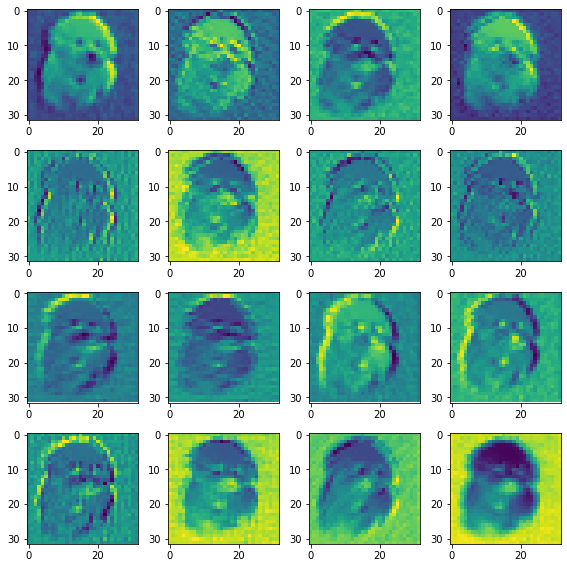

In [127]:
fig, axs = plt.subplots(4,4, figsize=(8,8))
axs = axs.ravel()
for ico in range(co):
    axs[ico].imshow(torout[ico])
plt.tight_layout()
plt.savefig("torch.png")